In [5]:

from tensorflow.keras.layers import Add,Multiply
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [8]:
low_light_folder = '/content/drive/MyDrive/Train/low'
high_light_folder = '/content/drive/MyDrive/Train/high'

image_size = (256, 256)

In [9]:
import cv2

def load_and_preprocess_image(image_path, target_size):

    try:
        # Load the image in grayscale mode
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image was loaded successfully
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {image_path}")

        # Resize the image to the target size
        image = cv2.resize(image, target_size)

        # Normalize the pixel values to the range [0, 1]
        image = image.astype('float32') / 255.0

        return image
    except Exception as e:
        print(f"Error loading or preprocessing image {image_path}: {e}")
        return None


In [10]:
import cv2
import os
import numpy as np
from tqdm import tqdm # Import tqdm here as well

def load_and_preprocess_image(image_path, target_size):
      try:
        # Load the image in grayscale mode
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image was loaded successfully
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {image_path}")

        # Resize the image to the target size
        image = cv2.resize(image, target_size)

        # Normalize the pixel values to the range [0, 1]
        image = image.astype('float32') / 255.0

        return image
      except Exception as e:
        print(f"Error loading or preprocessing image {image_path}: {e}")
        return None# ... (rest of the function remains the same)

def load_images(folder, target_size): # No changes to this line

    imgs = []
    print(f"Loading images from: {folder}")  # Debugging print statement

    for filename in tqdm(sorted(os.listdir(folder))): # Now tqdm is defined
        if filename.endswith(".png"):
            image_path = os.path.join(folder, filename)
            image = load_and_preprocess_image(image_path, target_size)
            if image is not None:
                imgs.append(image)
            else:
                print(f"Skipping image {filename} due to loading/preprocessing error.")

    return np.array(imgs) # Indent this line by adding 4 spaces

In [11]:
low_imgs = load_images(low_light_folder, image_size)
high_imgs = load_images(high_light_folder, image_size)

Loading images from: /content/drive/MyDrive/Train/low


100%|██████████| 486/486 [00:50<00:00,  9.62it/s]


Loading images from: /content/drive/MyDrive/Train/high


100%|██████████| 486/486 [00:30<00:00, 16.11it/s]


In [12]:
low_light_images = low_imgs.reshape(-1, image_size[0], image_size[1], 1)
high_light_images = high_imgs.reshape(-1, image_size[0], image_size[1], 1)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(low_light_images, high_light_images, test_size=0.3, random_state=42)

In [14]:
from tensorflow.keras.layers import Add,Multiply
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [15]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal

def unet_model(input_size=(256, 256, 1), base_filters=32, dropout_rate=0.5):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(base_filters, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(inputs)
    conv1 = Conv2D(base_filters, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(base_filters*2, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(pool1)
    conv2 = Conv2D(base_filters*2, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(base_filters*4, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(pool2)
    conv3 = Conv2D(base_filters*4, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(base_filters*8, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(pool3)
    conv4 = Conv2D(base_filters*8, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)

    conv5 = Conv2D(base_filters*16, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(pool4)
    conv5 = Conv2D(base_filters*16, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(conv5)
    conv5 = BatchNormalization()(conv5)

    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(base_filters*8, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(up6)
    conv6 = Conv2D(base_filters*8, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(base_filters*4, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(up7)
    conv7 = Conv2D(base_filters*4, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(base_filters*2, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(up8)
    conv8 = Conv2D(base_filters*2, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(base_filters, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(up9)
    conv9 = Conv2D(base_filters, 3, activation='relu', padding='same', kernel_initializer=HeNormal())(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

# Example usage
model = unet_model(input_size=(256, 256, 1), base_filters=32, dropout_rate=0.5)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 32)         320       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_19[0][0]']           
                                                                                                  
 batch_normalization_9 (Bat  (None, 256, 256, 32)         128       ['conv2d_20[0][0]']           
 chNormalization)                                                                           

In [22]:
# ... (Your existing unet_model function) ...
from sklearn.metrics import mean_absolute_error


# Example usage
model = unet_model(input_size=(256, 256, 1), base_filters=32, dropout_rate=0.5)
model.summary()

# Compile the model
model.compile(optimizer=Adam(), loss=tf.keras.losses.MeanAbsoluteError()) # Add this line to compile the model

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=4)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_95 (Conv2D)          (None, 256, 256, 32)         320       ['input_6[0][0]']             
                                                                                                  
 conv2d_96 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_95[0][0]']           
                                                                                                  
 batch_normalization_45 (Ba  (None, 256, 256, 32)         128       ['conv2d_96[0][0]']           
 tchNormalization)                                                                          

In [25]:
prediction = model.predict(x_val)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_val, prediction)]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

5/5 [==============================] - 16s 2s/step
Average PSNR: 19.3976965319323


In [26]:
from tensorflow.keras.layers import Add,Multiply
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


In [29]:
import cv2
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.optimizers import SGD


low_light_folder = '/content/drive/MyDrive/Train/low'
high_light_folder = '/content/drive/MyDrive/Train/high'

image_size = (256, 256)

import cv2
import numpy as np

def load_and_preprocess_image(image_path, target_size):
    # Load image using OpenCV
    image = cv2.imread(image_path)

    # Convert BGR to LAB color space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Resize image to target size
    image = cv2.resize(image, target_size)

    # Normalize image to [0, 1]
    image = image.astype('float32') / 255.0

    return image
def load_images(folder, target_size):
    images = []
    allowed_extensions = ['.png', '.jpg', '.jpeg']  # Allowed image extensions

    # Iterate through files in folder
    for filename in tqdm(sorted(os.listdir(folder))):
        if any(filename.lower().endswith(ext) for ext in allowed_extensions):
            image_path = os.path.join(folder, filename)
            image = load_and_preprocess_image(image_path, target_size)
            images.append(image)

    return np.array(images)


low_images = load_images(low_light_folder, image_size)
high_images = load_images(high_light_folder, image_size)
low_light_images = low_images.reshape(-1, image_size[0], image_size[1], 3)
high_light_images = high_images.reshape(-1, image_size[0], image_size[1], 3)


100%|██████████| 486/486 [00:07<00:00, 63.77it/s]


In [30]:
X_train, X_val, y_train, y_val = train_test_split(low_light_images, high_light_images, test_size=0.1, random_state=42)

In [34]:
# from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import BinaryCrossentropy

# Assuming you are using a sequential model or a functional model
model.compile(optimizer='adam', loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy'])


In [36]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def residual_block_lab(x, filters):
    # Residual block with LAB color space adaptation
    y = Conv2D(filters, 3, activation='relu', padding='same')(x)
    y = Conv2D(filters, 3, activation='relu', padding='same')(y)
    return concatenate([x, y], axis=-1)  # Concatenate input with residual connection

def unet_model_with_residuals_lab(input_size=(256, 256, 3)):
    num_filters = 32  # Define the number of filters as a variable

    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(num_filters, 3, activation='relu', padding='same')(inputs)
    conv1 = residual_block_lab(conv1, num_filters)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(num_filters * 2, 3, activation='relu', padding='same')(pool1)
    conv2 = residual_block_lab(conv2, num_filters * 2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(num_filters * 4, 3, activation='relu', padding='same')(pool2)
    conv3 = residual_block_lab(conv3, num_filters * 4)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(num_filters * 8, 3, activation='relu', padding='same')(pool3)
    conv4 = residual_block_lab(conv4, num_filters * 8)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(num_filters * 16, 3, activation='relu', padding='same')(pool4)
    conv5 = residual_block_lab(conv5, num_filters * 16)

    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(num_filters * 8, 3, activation='relu', padding='same')(up6)
    conv6 = residual_block_lab(conv6, num_filters * 8)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(num_filters * 4, 3, activation='relu', padding='same')(up7)
    conv7 = residual_block_lab(conv7, num_filters * 4)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(num_filters * 2, 3, activation='relu', padding='same')(up8)
    conv8 = residual_block_lab(conv8, num_filters * 2)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(num_filters, 3, activation='relu', padding='same')(up9)
    conv9 = residual_block_lab(conv9, num_filters)

    # Output layer
    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)  # Output with 3 channels for HSV

    model = Model(inputs=inputs, outputs=conv10)
    return model


In [41]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

# Assuming unet_model_with_residuals_lab is defined as per the previous response

# Instantiate the U-Net model
model_lab = unet_model_with_residuals_lab()

# Compile the model with Adam optimizer and Mean Absolute Error loss
model_lab.compile(optimizer=Adam(learning_rate=1e-4, clipvalue=1.0), loss=MeanAbsoluteError())

# Set GPU memory growth option
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

# Train the model with modified epochs and batch size
history=model_lab.fit(X_train, y_train,
              epochs=75,  # Increase the number of epochs
              batch_size=4
             )

# Remember to close the session after training
session.close()


/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch 1/75
109/109 [==============================] - 27s 167ms/step - loss: 0.0729
Epoch 2/75
109/109 [==============================] - 18s 167ms/step - loss: 0.0679
Epoch 3/75
109/109 [==============================] - 18s 168ms/step - loss: 0.0625
Epoch 4/75
109/109 [==============================] - 18s 168ms/step - loss: 0.0600
Epoch 5/75
109/109 [==============================] - 18s 169ms/step - loss: 0.0583
Epoch 6/75
109/109 [==============================] - 18s 170ms/step - loss: 0.0564
Epoch 7/75
109/109 [==============================] - 19s 170ms/step - loss: 0.0560
Epoch 8/75
109/109 [==============================] - 19s 171ms/step - loss: 0.0540
Epoch 9/75
109/109 [==============================] - 19s 171ms/step - loss: 0.0534
Epoch 10/75
109/109 [==============================] - 19s 171ms/step - loss: 0.0531
Epoch 11/75
109/109 [==============================] - 19s 171ms/step - loss: 0.0514
Epoch 12/75
109/109 [==============================] - 19s 171ms/step - lo

In [38]:
from skimage.metrics import peak_signal_noise_ratio

# Assuming `model_lab` is already defined and trained

# Perform predictions on validation data
predictions = model_lab.predict(X_val)

# Calculate PSNR values for each pair of true and predicted images
psnr_values = [peak_signal_noise_ratio(y_true, y_pred) for y_true, y_pred in zip(y_val, predictions)]

# Compute the average PSNR
average_psnr = np.mean(psnr_values)

# Print the average PSNR
print(f'Average PSNR: {average_psnr}')


2/2 [==============================] - 16s 7s/step
Average PSNR: 25.387008971788504


KeyError: 'val_loss'

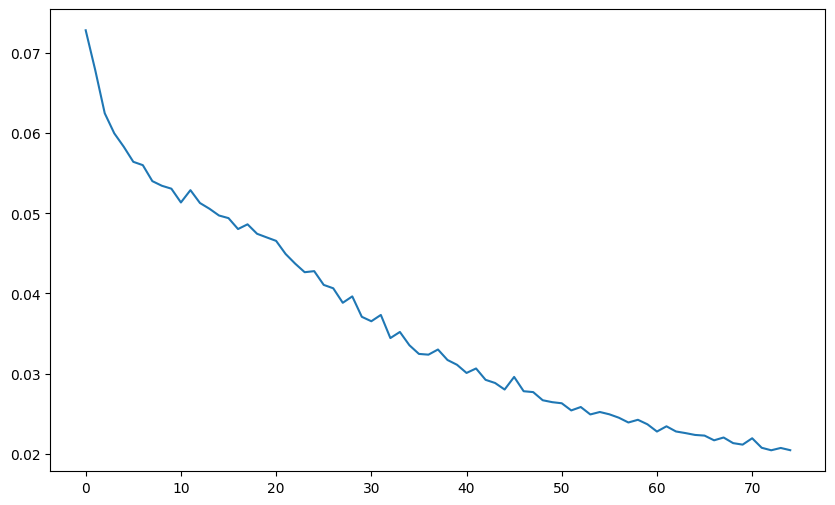

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
import os
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [44]:
directory = '/content/drive/MyDrive/Train'

noisy_dir=os.path.join(directory, 'low')
clean_dir=os.path.join(directory, 'high')

In [45]:
all_filenames=os.listdir(noisy_dir)

In [46]:
import matplotlib.pyplot as plt
def random_image_plot(file, path1, path2):
    # Select a random image name from the file list
    name = np.random.choice(file)

    try:
        # Load and normalize the dark image
        dark_image_path = os.path.join(path1, name)
        dark_image = img_to_array(load_img(dark_image_path, target_size=(256, 256))) / 255.0

        # Load and normalize the light image
        light_image_path = os.path.join(path2, name)
        light_image = img_to_array(load_img(light_image_path, target_size=(256, 256))) / 255.0

        # Create a subplot with 2 images side by side
        fig, axes = plt.subplots(1, 2, figsize=(8, 8))

        # Plot the dark image
        axes[0].imshow(dark_image)
        axes[0].set_title('UNDEREXPOSED')
        axes[0].axis('on')

        # Plot the light image
        axes[1].imshow(light_image)
        axes[1].set_title('EXPOSED')
        axes[1].axis('on')

        # Display the plot
        plt.show()
    except FileNotFoundError as e:
        print(f"Error: {e}")

# Example usage
# files = ['image1.jpg', 'image2.jpg', ...]  # list of image filenames
# random_image_plot(files, 'path_to_dark_images', 'path_to_light_images')

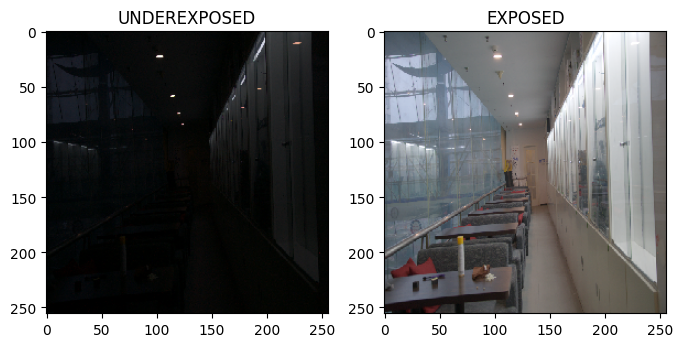

In [47]:
random_image_plot(all_filenames,noisy_dir,clean_dir)